## Image classification
- Azure Custom Vision - Image Classification Project

##### Importing utility functions and Python modules

In [1]:
import requests
from urllib.parse import urlparse
from io import BytesIO
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

import os, time, uuid

from azure.cognitiveservices.vision.customvision.training import CustomVisionTrainingClient
from azure.cognitiveservices.vision.customvision.prediction import CustomVisionPredictionClient
from azure.cognitiveservices.vision.customvision.training.models import ImageFileCreateBatch, ImageFileCreateEntry, Region
from msrest.authentication import ApiKeyCredentials

##### Training and Prediction Endpoint, Key and Resource ID separately

##### need:
- Azure Custom Vision Endpoint
- Traning Reource ID and Key
- Prediction Resource ID and Key

In [2]:
TRAINING_ENDPOINT= "-----------------------------------------"
training_key = "-------------------------------------------"
training_resource_id = "-----------------------------------------"

In [3]:
PREDICTION_ENDPOINT = "-----------------------------------------"
prediction_key = "-----------------------------------------"
prediction_resource_id = "-----------------------------------------"

##### Instantiate and authenticate the training client with endpoint and key 

In [4]:
training_credentials = ApiKeyCredentials(in_headers={"Training-key": training_key})
trainer = CustomVisionTrainingClient(TRAINING_ENDPOINT, training_credentials)

In [5]:
trainer.api_version

'3.4-preview'

##### For an exportable (to edge devices) model

In [6]:
for domain in trainer.get_domains():
  print(domain.id, "\t", domain.name) 

2e37d7fb-3a54-486a-b4d6-cfc369af0018 	 General [A2]
a8e3c40f-fb4a-466f-832a-5e457ae4a344 	 General [A1]
ee85a74c-405e-4adc-bb47-ffa8ca0c9f31 	 General
c151d5b5-dd07-472a-acc8-15d29dea8518 	 Food
ca455789-012d-4b50-9fec-5bb63841c793 	 Landmarks
b30a91ae-e3c1-4f73-a81e-c270bff27c39 	 Retail
45badf75-3591-4f26-a705-45678d3e9f5f 	 Adult
a1db07ca-a19a-4830-bae8-e004a42dc863 	 General (compact) [S1]
0732100f-1a38-4e49-a514-c9b44c697ab5 	 General (compact)
8882951b-82cd-4c32-970b-d5f8cb8bf6d7 	 Food (compact)
b5cfd229-2ac7-4b2b-8d0a-2b0661344894 	 Landmarks (compact)
6b4faeda-8396-481b-9f8b-177b9fa3097f 	 Retail (compact)
9c616dff-2e7d-ea11-af59-1866da359ce6 	 General [A1]
da2e3a8a-40a5-4171-82f4-58522f70fbc1 	 General
1d8ffafe-ec40-4fb2-8f90-72b3b6cecea4 	 Logo
3780a898-81c3-4516-81ae-3a139614e1f3 	 Products on Shelves
7ec2ac80-887b-48a6-8df9-8b1357765430 	 General (compact) [S1]
a27d5ca5-bb19-49d8-a70a-fec086c47f5b 	 General (compact)


##### Creating Training Project

In [7]:
# Todo: create a new project
print ("Training project created. Please move on.")
project_name = uuid.uuid4()
# To change the project classification type, you can set classification_type = 'Multiclass'.
project = trainer.create_project(name= project_name, description= "img-classification-project", domain_id= "0732100f-1a38-4e49-a514-c9b44c697ab5")
# Getting Project Details as collective information 
project.as_dict()

Training project created. Please move on.


{'id': '592d89c6-7529-4be3-a5f8-b9ed084da45c',
 'name': 'c0a72517-aeee-4786-a080-397121b3e198',
 'description': 'img-classification-project',
 'settings': {'domain_id': '0732100f-1a38-4e49-a514-c9b44c697ab5',
  'classification_type': 'Multilabel',
  'target_export_platforms': [],
  'use_negative_set': True,
  'image_processing_settings': {'augmentation_methods': {'rotation': True,
    'scaling': True,
    'translation': True,
    'horizontal flip': True,
    'equalize': True,
    'solarize': True,
    'padtosquare': True}}},
 'created': '2023-09-05T01:01:40.536Z',
 'last_modified': '2023-09-05T01:01:40.536Z',
 'dr_mode_enabled': False,
 'status': 'Succeeded'}

##### Adding Tags

In [8]:
fork_tag = trainer.create_tag(project.id, "fork")

In [9]:
scissors_tag = trainer.create_tag(project.id, "scissors")

##### Upload Traning Data

In [10]:
# Code taken from Azure SDK Sample. No need to change it
def upload_images_for_training(local_project_id, local_image_path, local_img_folder_name, image_tag_id):
    image_list = []
    files = os.listdir(os.path.join (local_image_path, local_img_folder_name))
    for file in files:
        full_path = os.path.join(local_image_path, local_img_folder_name, file)
        if os.path.isfile(full_path) and full_path.endswith('.jpg'):
            with open(os.path.join (local_image_path, local_img_folder_name, file), "rb") as image_contents:
                image_list.append(ImageFileCreateEntry(name=file, contents=image_contents.read(), tag_ids=[image_tag_id]))
                
    upload_result = trainer.create_images_from_files(local_project_id, ImageFileCreateBatch(images=image_list))
    if not upload_result.is_batch_successful:
        print("Image batch upload failed.")
        for image in upload_result.images:
            print("Image status: ", image.status)
        exit(-1)
    return upload_result

In [11]:
local_image_path = os.path.join(os.getcwd(), 'Images')

In [12]:
# Todo: update the image path
fork_folder_name = 'fork'

# Todo: upload images. Make sure to upload images for ALL classes/tags
result_tag1 = upload_images_for_training(project.id, local_image_path, fork_folder_name, fork_tag.id)

In [13]:
# Todo: check if images for ALL tags are successfully uploaded.
result_tag1.is_batch_successful

True

In [14]:
# Todo: update the image path
scissors_folder_name = 'scissors'

# Todo: upload images. Make sure to upload images for ALL classes/tags
result_tag2 = upload_images_for_training(project.id, local_image_path, scissors_folder_name, scissors_tag.id)

In [15]:
# Todo: check if images for ALL tags are successfully uploaded.
result_tag2.is_batch_successful

True

##### Start the Image Classification Training

In [16]:
# Todo: set the train_project object
iteration = trainer.train_project(project.id)

# We will be keep checking every 10 seconds the training progress
while (iteration.status != "Completed"):
    iteration = trainer.get_iteration(project.id, iteration.id)
    print ("Training status: " + iteration.status)
    print ("Waiting 10 seconds...")
    time.sleep(10)

Training status: Training
Waiting 10 seconds...
Training status: Training
Waiting 10 seconds...
Training status: Training
Waiting 10 seconds...
Training status: Training
Waiting 10 seconds...
Training status: Training
Waiting 10 seconds...
Training status: Training
Waiting 10 seconds...
Training status: Training
Waiting 10 seconds...
Training status: Training
Waiting 10 seconds...
Training status: Training
Waiting 10 seconds...
Training status: Training
Waiting 10 seconds...
Training status: Training
Waiting 10 seconds...
Training status: Training
Waiting 10 seconds...
Training status: Training
Waiting 10 seconds...
Training status: Training
Waiting 10 seconds...
Training status: Training
Waiting 10 seconds...
Training status: Training
Waiting 10 seconds...
Training status: Training
Waiting 10 seconds...
Training status: Training
Waiting 10 seconds...
Training status: Training
Waiting 10 seconds...
Training status: Training
Waiting 10 seconds...
Training status: Training
Waiting 10 sec

##### Get the Model Performance

In [17]:
iteration.as_dict()

{'id': 'e30697d2-4cb3-45af-8ce6-9750bbfea05c',
 'name': 'Iteration 1',
 'status': 'Completed',
 'created': '2023-09-05T01:01:40.543Z',
 'last_modified': '2023-09-05T01:06:11.177Z',
 'trained_at': '2023-09-05T01:06:11.139Z',
 'project_id': '592d89c6-7529-4be3-a5f8-b9ed084da45c',
 'exportable': True,
 'domain_id': '0732100f-1a38-4e49-a514-c9b44c697ab5',
 'classification_type': 'Multilabel',
 'training_type': 'Regular',
 'reserved_budget_in_hours': 0,
 'training_time_in_minutes': 1}

In [18]:
iteration_list = trainer.get_iterations(project.id)
for iteration_item in iteration_list:
    print(iteration_item)

{'additional_properties': {}, 'id': 'e30697d2-4cb3-45af-8ce6-9750bbfea05c', 'name': 'Iteration 1', 'status': 'Completed', 'created': datetime.datetime(2023, 9, 5, 1, 1, 40, 543000, tzinfo=<isodate.tzinfo.Utc object at 0x7f3533a77ca0>), 'last_modified': datetime.datetime(2023, 9, 5, 1, 6, 11, 177000, tzinfo=<isodate.tzinfo.Utc object at 0x7f3533a77ca0>), 'trained_at': datetime.datetime(2023, 9, 5, 1, 6, 11, 139000, tzinfo=<isodate.tzinfo.Utc object at 0x7f3533a77ca0>), 'project_id': '592d89c6-7529-4be3-a5f8-b9ed084da45c', 'exportable': True, 'exportable_to': None, 'domain_id': '0732100f-1a38-4e49-a514-c9b44c697ab5', 'classification_type': 'Multilabel', 'training_type': 'Regular', 'reserved_budget_in_hours': 0, 'training_time_in_minutes': 1, 'publish_name': None, 'original_publish_resource_id': None, 'custom_base_model_info': None, 'training_error_details': None}


In [19]:
# Todo: get the model performance
model_perf = trainer.get_iteration_performance(project.id, iteration_list[0].id)

In [20]:
# Evaluate model performance by looking at the precision and recall values.
model_perf.as_dict()

{'per_tag_performance': [{'id': '4b710af4-e964-4696-94b0-a7bcfb3f7658',
   'name': 'fork',
   'precision': 1.0,
   'precision_std_deviation': 0.0,
   'recall': 1.0,
   'recall_std_deviation': 0.0,
   'average_precision': 1.0},
  {'id': 'c015334f-1f61-4f73-9a6d-7bdefa1994a0',
   'name': 'scissors',
   'precision': 1.0,
   'precision_std_deviation': 0.0,
   'recall': 1.0,
   'recall_std_deviation': 0.0,
   'average_precision': 1.0}],
 'precision': 1.0,
 'precision_std_deviation': 0.0,
 'recall': 1.0,
 'recall_std_deviation': 0.0,
 'average_precision': 1.0}

##### Add more images and perform more training iterations to improve your model performance.

In [21]:
# more training here...
local_image_path2 = os.path.join(os.getcwd(), 'Images2')

In [22]:
# Todo: update the image path
fork_folder_name = 'fork'

# Todo: upload images. Make sure to upload images for ALL classes/tags
it2_result_tag1 = upload_images_for_training(project.id, local_image_path2, fork_folder_name, fork_tag.id)

In [23]:
# Todo: check if images for ALL tags are successfully uploaded.
it2_result_tag1.is_batch_successful

True

In [24]:
# Todo: update the image path
scissors_folder_name = 'scissors'

# Todo: upload images. Make sure to upload images for ALL classes/tags
it2_result_tag2 = upload_images_for_training(project.id, local_image_path2, scissors_folder_name, scissors_tag.id)

In [25]:
# Todo: check if images for ALL tags are successfully uploaded.
it2_result_tag2.is_batch_successful

True

In [26]:
# Todo: set the train_project object
iteration2 = trainer.train_project(project.id)

# We will be keep checking every 10 seconds the training progress
while (iteration2.status != "Completed"):
    iteration2 = trainer.get_iteration(project.id, iteration2.id)
    print ("Training status: " + iteration2.status)
    print ("Waiting 10 seconds...")
    time.sleep(10)

Training status: Training
Waiting 10 seconds...
Training status: Training
Waiting 10 seconds...
Training status: Training
Waiting 10 seconds...
Training status: Training
Waiting 10 seconds...
Training status: Training
Waiting 10 seconds...
Training status: Training
Waiting 10 seconds...
Training status: Training
Waiting 10 seconds...
Training status: Training
Waiting 10 seconds...
Training status: Training
Waiting 10 seconds...
Training status: Training
Waiting 10 seconds...
Training status: Training
Waiting 10 seconds...
Training status: Training
Waiting 10 seconds...
Training status: Training
Waiting 10 seconds...
Training status: Training
Waiting 10 seconds...
Training status: Training
Waiting 10 seconds...
Training status: Training
Waiting 10 seconds...
Training status: Training
Waiting 10 seconds...
Training status: Training
Waiting 10 seconds...
Training status: Training
Waiting 10 seconds...
Training status: Training
Waiting 10 seconds...
Training status: Training
Waiting 10 sec

In [27]:
iteration2.as_dict()

{'id': 'e418ea06-c058-4fbb-bf90-92ad1959ad64',
 'name': 'Iteration 2',
 'status': 'Completed',
 'created': '2023-09-05T01:02:03.443Z',
 'last_modified': '2023-09-05T01:10:20.092Z',
 'trained_at': '2023-09-05T01:10:20.052Z',
 'project_id': '592d89c6-7529-4be3-a5f8-b9ed084da45c',
 'exportable': True,
 'domain_id': '0732100f-1a38-4e49-a514-c9b44c697ab5',
 'classification_type': 'Multilabel',
 'training_type': 'Regular',
 'reserved_budget_in_hours': 0,
 'training_time_in_minutes': 1}

In [28]:
iteration_list = trainer.get_iterations(project.id)
for iteration_item in iteration_list:
    print(iteration_item)

{'additional_properties': {}, 'id': 'e418ea06-c058-4fbb-bf90-92ad1959ad64', 'name': 'Iteration 2', 'status': 'Completed', 'created': datetime.datetime(2023, 9, 5, 1, 2, 3, 443000, tzinfo=<isodate.tzinfo.Utc object at 0x7f3533a77ca0>), 'last_modified': datetime.datetime(2023, 9, 5, 1, 10, 20, 92000, tzinfo=<isodate.tzinfo.Utc object at 0x7f3533a77ca0>), 'trained_at': datetime.datetime(2023, 9, 5, 1, 10, 20, 52000, tzinfo=<isodate.tzinfo.Utc object at 0x7f3533a77ca0>), 'project_id': '592d89c6-7529-4be3-a5f8-b9ed084da45c', 'exportable': True, 'exportable_to': None, 'domain_id': '0732100f-1a38-4e49-a514-c9b44c697ab5', 'classification_type': 'Multilabel', 'training_type': 'Regular', 'reserved_budget_in_hours': 0, 'training_time_in_minutes': 1, 'publish_name': None, 'original_publish_resource_id': None, 'custom_base_model_info': None, 'training_error_details': None}
{'additional_properties': {}, 'id': 'e30697d2-4cb3-45af-8ce6-9750bbfea05c', 'name': 'Iteration 1', 'status': 'Completed', 'crea

In [29]:
# Todo: get the model performance
model_perf = trainer.get_iteration_performance(project.id, iteration_list[0].id)

In [30]:
# Evaluate model performance by looking at the precision and recall values.
model_perf.as_dict()

{'per_tag_performance': [{'id': '4b710af4-e964-4696-94b0-a7bcfb3f7658',
   'name': 'fork',
   'precision': 1.0,
   'precision_std_deviation': 0.0,
   'recall': 1.0,
   'recall_std_deviation': 0.0,
   'average_precision': 1.0},
  {'id': 'c015334f-1f61-4f73-9a6d-7bdefa1994a0',
   'name': 'scissors',
   'precision': 1.0,
   'precision_std_deviation': 0.0,
   'recall': 1.0,
   'recall_std_deviation': 0.0,
   'average_precision': 1.0}],
 'precision': 1.0,
 'precision_std_deviation': 0.0,
 'recall': 1.0,
 'recall_std_deviation': 0.0,
 'average_precision': 1.0}

##### Publishing the Model to the Project Endpoint

In [31]:
# Todo: set the Iteration Name. This will be used when Model training is completed
publish_iteration_name = "img-classification-second-iteration"

In [32]:
# Todo: publish it to the project endpoint
trainer.publish_iteration(project.id, iteration_list[0].id, publish_iteration_name, prediction_resource_id)
print ("Done!")

Done!


##### Performing Prediction

In [33]:
# Instantiate and authenticate the prediction client with endpoint and key
prediction_credentials = ApiKeyCredentials(in_headers={"Prediction-key": prediction_key})
predictor = CustomVisionPredictionClient(PREDICTION_ENDPOINT, prediction_credentials)
predictor.api_version

'3.1'

In [34]:
# Todo: define a function to use the predictor object.
from numpy import imag


def perform_prediction(image_file_name):
    with open(os.path.join (local_image_path,  image_file_name), "rb") as image_contents:
        # Todo: set the predictor object to classify the image.
        results = predictor.classify_image(project.id, publish_iteration_name, image_contents.read())
        # Display the results.
        for prediction in results.predictions:
            print("\t" + prediction.tag_name +
                  ": {0:.2f}%".format(prediction.probability * 100))

In [35]:
# Todo: set the image that you want to perform prediction. Make sure the image is under the right path.
file_name = 'test_image.jpg'
local_image_path = local_image_path = os.path.join(os.getcwd(), 'test')

In [36]:
# Todo: call the perform_prediction function to make the prediction
perform_prediction(file_name)

	fork: 99.99%
	scissors: 0.01%


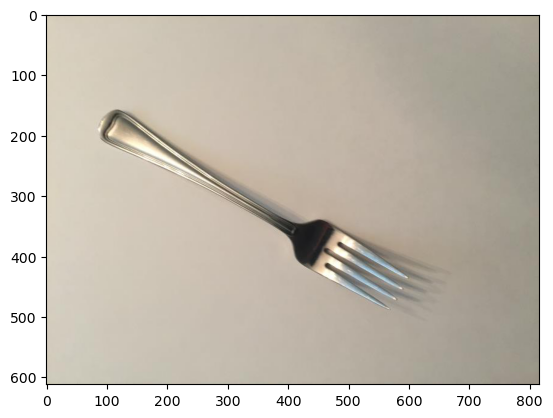

In [37]:
# Check the Image
with open(os.path.join (local_image_path, file_name), 'rb') as img_code:
    img_view_ready = Image.open(img_code)
    plt.figure()
    plt.imshow(img_view_ready)

##### Export Model (optional)
- You can download the model so it can be used outside Azure. Note: this step may take a very long time.

In [38]:
print("Project ID: ", project.id)

Project ID:  592d89c6-7529-4be3-a5f8-b9ed084da45c


In [39]:
all_iterations = trainer.get_iterations(project.id)

In [40]:
# Check if the iteration is exportable
for index, each_iteration in enumerate(all_iterations):
    print("|--------- Iteration [{}] --------".format(index))
    print("Iteration ID: ",each_iteration.id)
    print("Iteration Name: ",each_iteration.name)
    print("Iteration Exportable: ",each_iteration.exportable)
    print("-----------------------------------------------------")

|--------- Iteration [0] --------
Iteration ID:  e418ea06-c058-4fbb-bf90-92ad1959ad64
Iteration Name:  Iteration 2
Iteration Exportable:  True
-----------------------------------------------------
|--------- Iteration [1] --------
Iteration ID:  e30697d2-4cb3-45af-8ce6-9750bbfea05c
Iteration Name:  Iteration 1
Iteration Exportable:  True
-----------------------------------------------------


Above please verify that your project-> Iteration must be exportalble
- Iteration Exportable: True

Make sure there are exportable iterations. If none of the iteration is exportable, follow these steps:
* Go to the Custom Vision portal
* Select a project and change your project setting to support the compact domain
* Create another iteration for model training

You can check the *"Azure Custom Vision Portal Demo 5: Export a Model"* video for how to perform these steps.

Then you can rerun the cells above.

In [41]:
# Todo: change the all_iterations index. Make sure the iterations is the exportable.
selected_iteration_id = all_iterations[1].id
print(selected_iteration_id)

e30697d2-4cb3-45af-8ce6-9750bbfea05c


In [42]:
# Using the TensorFlow platform
platform = "TensorFlow"
flavor = "TensorFlowLite"

In [43]:
# Use the export object to expert the project and trained model
export_process = trainer.export_iteration(project.id, selected_iteration_id, platform, flavor, raw=True)

In [44]:
print(export_process.output)

{'additional_properties': {}, 'platform': 'TensorFlow', 'status': 'Exporting', 'download_uri': None, 'flavor': 'TensorFlowLite', 'newer_version_available': False}


In [45]:
print(export_process.output.status)

Exporting


In [48]:
# Code snippet is from Azure SDK and Documentation
# https://docs.microsoft.com/en-us/azure/cognitive-services/custom-vision-service/export-programmatically
# Note: this step may take long time 
while (export_process.output.status == "Exporting"):
    print ("Waiting 10 seconds...")
    time.sleep(10)
    exports = trainer.get_exports(project.id, selected_iteration_id)
    for e in exports:
        if e.platform == export_process.output.platform and e.flavor == export_process.output.flavor:
            export = e
            break
    print("Export status is: ", export_process.output.status)

Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export st

KeyboardInterrupt: 

In [ ]:
print(export_process.output.status)

In [ ]:
print(export_process.output.download_uri)

In [ ]:
## Downloading the model from url
if export_process.output.status == "Done":
    # Ready to Download. You can choose any preferred name of the file.
    model_export_file = requests.get(export_process.output.download_uri)
    with open("model.zip", "wb") as file:
        file.write(model_export_file.content)